In [1]:
from sklearn.linear_model import (
    LinearRegression,
    RidgeCV,
    BayesianRidge,
    Ridge,
    ElasticNetCV,
    ElasticNet,
    Lasso,
    LassoCV,
    LarsCV,
    LassoLarsCV,
    SGDRegressor,
    TheilSenRegressor,
    RANSACRegressor,
)
from sklearn.svm import SVR
from sklearn.kernel_ridge import KernelRidge
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import BaggingRegressor, RandomForestRegressor
from sklearn.model_selection import cross_val_score, LeaveOneOut, KFold, RepeatedKFold
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import PolynomialFeatures
import pandas as pd
import numpy as np
import itertools
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from pathlib import Path

INPUT_PATH = Path("/mnt/storage_dimm2/kaggle_data/commonlitreadabilityprize")
OUTPUT_PATH = Path("/mnt/storage_dimm2/kaggle_output/commonlitreadabilityprize")

In [2]:
model_folders = [
    # cherubic-nifty-serval - deberta-large - 0.4836
    "20210614-173633",
    "20210614-203831",
    "20210614-234025",
    "20210615-024138",
    "20210615-054256",
    # scrupulous-mink-of-amplitude - deberta-base - 0.4934
    "20210615-084357",
    "20210615-094729",
    "20210615-105329",
    "20210615-120001",
    "20210615-130640",
    # notorious-sticky-gibbon - roberta-base (with hidden) - 0.4961
    "20210615-220146",
    "20210615-225055",
    "20210615-234038",
    "20210616-003038",
    "20210616-012048",
    # fortunate-cherry-mandrill - roberta-large - 0.4890
    "20210616-021135",
    "20210616-041221",
    "20210616-060255",
    "20210616-075451",
    "20210616-094506",
    # mottled-certain-caracal - distilroberta-base - 0.5076
    "20210616-113626",
    "20210616-121203",
    "20210616-124738",
    "20210616-132341",
    "20210616-140300",
    # aspiring-classic-pegasus - funnel - 0.4975
    "20210617-083847", 
    "20210617-102611", 
    "20210617-120949", 
    "20210617-135233", 
    "20210617-153459", 
    # silver-bumblebee-of-attack - roberta-base - 0.4932
    "20210617-223340",
    "20210617-232650",
    "20210618-002022",
    "20210618-011405",
    "20210618-020751",
    # sloppy-resourceful-tanuki - albert-large - 0.5241
    "20210617-225903",
    "20210618-010302",
    "20210618-030706",
    "20210618-051049",
    "20210618-071437",
    # rustling-quirky-mastodon - bert-base-uncased - 0.5136
    "20210618-082756",
    "20210618-092115",
    "20210618-100526",
    "20210618-105909",
    "20210618-115253",
    # perky-defiant-husky - bert-large-uncased - 0.5287
    "20210618-124637",
    "20210618-144213",
    "20210618-163942",
    "20210618-183719",
    "20210618-203441",
    # gregarious-brass-perch - bart-base - 0.5445
    "20210618-223208",
    "20210618-233614",
    "20210619-004022",
    "20210619-014809",
    "20210619-025421",
    # military-firefly-of-apotheosis - bart-large - 0.5301
    "20210619-035747",
    "20210619-064351",
    "20210619-093050",
    "20210619-121916",
    "20210619-150740",
    # eccentric-lemur-of-tenacity - sentence-transformers/LaBSE - 0.5230
    "20210622-152356",
    "20210622-161822",
    "20210622-171312",
    "20210622-181238",
    "20210622-191326",
    # valiant-chameleon-of-chaos - sentence-transformers/bert-base-nli-cls-token - 0.5288
    "20210622-165808",
    "20210622-174555",
    "20210622-183427",
    "20210622-192221",
    "20210622-201127",
    # nonchalant-quaint-termite - roberta-base - 0.4951
    "20210623-093223",
    "20210623-101956",
    "20210623-110954",
    "20210623-120004",
    "20210623-125025",
    # skilled-smart-crane - deberta-large (new seeds) - 0.4758
    "20210623-105940",
    "20210623-140343",
    "20210623-170657",
    "20210623-201514",
    "20210623-232231",
    # winged-cerise-agouti - roberta-large - 0.4986
    "20210623-134115",
    "20210623-153240",
    "20210623-172217",
    "20210623-191151",
    "20210623-210342",
    # swift-of-amazing-pride - distilroberta-base - 0.5053
    "20210623-225426",
    "20210623-233019",
    "20210624-000706",
    "20210624-004429",
    "20210624-012102",
    # independent-discerning-earthworm - albert-large-v2
    "20210624-015812",
    "20210624-040309",
    "20210624-060838",
    "20210624-081317",
    "20210624-101855",
    # discreet-visionary-seahorse - microsoft/deberta-base - 0.5181
    "20210624-023057",
    "20210624-033624",
    "20210624-044356",
    "20210624-055212",
    "20210624-070123",
    # chirpy-wren-of-unity - funnel-transformer/large-base
    "20210624-081031",
    "20210624-095223",
    "20210624-113506",
    "20210624-131927",
    "20210624-150250",
    
]

print(len(model_folders))

dataset_paths = [OUTPUT_PATH / f for f in model_folders]

105


In [3]:
mpaths, oof_paths = [], []
for p in dataset_paths:
    mpaths.append(sorted(list(p.glob(f"*/*/*.ckpt"))))
    oof_paths.extend(sorted(list(p.glob(f"*.csv"))))
    
len(model_folders), len(oof_paths)

(105, 105)

In [4]:
oofs = pd.read_csv(INPUT_PATH / "train.csv", usecols=["id", "target", "standard_error"]).sort_values(
        by="id"
    )
for i, (p, f) in enumerate(zip(oof_paths, model_folders)):
    x = pd.read_csv(p).sort_values(by="id")
    oofs[f] = x["prediction"].values

# pred_cols = [f"model_{i}" for i in range(len(mpaths))]
pred_cols = model_folders

print(len(pred_cols))
    
oofs.head()

105


,id,target,standard_error,20210614-173633,20210614-203831,20210614-234025,20210615-024138,20210615-054256,20210615-084357,20210615-094729,...,20210624-023057,20210624-033624,20210624-044356,20210624-055212,20210624-070123,20210624-081031,20210624-095223,20210624-113506,20210624-131927,20210624-150250
1279,000accf7e,-2.002055,0.497274,-2.174165,-2.305160,-2.451190,-2.505858,-2.490587,-2.264506,-2.664520,...,-2.329115,-2.495445,-2.572108,-2.386018,-2.501415,-2.236920,-2.195285,-2.268863,-2.183417,-2.121923
2185,001ef05a9,0.841000,0.492411,0.669889,0.569387,0.472606,0.514734,0.493645,0.528904,0.495011,...,0.367440,0.564856,0.491353,0.494037,0.196787,0.245238,0.279476,0.676372,0.330868,0.207034
332,00589d631,-2.195109,0.520239,-1.908255,-1.930197,-2.064695,-2.545308,-2.129548,-2.160540,-2.234235,...,-2.358351,-2.123116,-2.334685,-2.515972,-2.442772,-1.734213,-1.916465,-2.349501,-2.171746,-2.342350
72,0060c36b9,-1.333456,0.492384,-1.098570,-1.134784,-1.161226,-1.260594,-1.139692,-0.983574,-1.220255,...,-1.000503,-0.661952,-0.919880,-1.010663,-1.062131,-1.076815,-0.992014,-1.129593,-0.996934,-1.140424
2694,00d4d251d,0.088764,0.463817,-0.226934,-0.034609,-0.219147,-0.192564,0.082993,-0.454333,-0.133543,...,-0.129533,-0.065892,-0.069638,-0.004368,-0.208849,0.140961,0.228167,0.183794,-0.036221,0.030975


In [5]:
oofs.describe()

,target,standard_error,20210614-173633,20210614-203831,20210614-234025,20210615-024138,20210615-054256,20210615-084357,20210615-094729,20210615-105329,...,20210624-023057,20210624-033624,20210624-044356,20210624-055212,20210624-070123,20210624-081031,20210624-095223,20210624-113506,20210624-131927,20210624-150250
count,2834.000000,2834.000000,2834.000000,2834.000000,2834.000000,2834.000000,2834.000000,2834.000000,2834.000000,2834.000000,...,2834.000000,2834.000000,2834.000000,2834.000000,2834.000000,2834.000000,2834.000000,2834.000000,2834.000000,2834.000000
mean,-0.959319,0.491435,-0.948092,-0.939186,-0.936123,-0.968496,-0.958907,-0.891844,-0.910382,-0.932254,...,-0.924137,-0.887664,-0.874430,-0.879372,-0.890812,-0.878059,-0.886871,-0.931421,-0.871524,-0.908374
std,1.033579,0.034818,0.912312,0.889185,0.913707,0.930968,0.905059,0.907261,0.927470,0.911461,...,0.956863,0.908805,0.903742,0.904796,0.892041,0.911266,0.885822,0.895317,0.894591,0.890064
min,-3.676268,0.000000,-3.560785,-3.392829,-3.732013,-3.534283,-3.483280,-3.612729,-3.607502,-3.599687,...,-3.513874,-3.645314,-3.472515,-3.555552,-3.815192,-3.310298,-3.678395,-3.506943,-3.460593,-3.440242
25%,-1.690320,0.468543,-1.613250,-1.570393,-1.616401,-1.659845,-1.625832,-1.550567,-1.581456,-1.592230,...,-1.653099,-1.566266,-1.538977,-1.553330,-1.540376,-1.559560,-1.538095,-1.597370,-1.545105,-1.553316
50%,-0.912190,0.484721,-0.900925,-0.891787,-0.904669,-0.926716,-0.913854,-0.845645,-0.853657,-0.858941,...,-0.872998,-0.804413,-0.803098,-0.818333,-0.818754,-0.845564,-0.820515,-0.882407,-0.820587,-0.880777
75%,-0.202540,0.506268,-0.242909,-0.258008,-0.232878,-0.260776,-0.254002,-0.191775,-0.206128,-0.229850,...,-0.175542,-0.186889,-0.163559,-0.179081,-0.213426,-0.160755,-0.194150,-0.237809,-0.165338,-0.205997
max,1.711390,0.649671,1.249225,1.150385,1.232993,1.288711,1.167053,1.241939,1.432130,1.164523,...,1.336429,1.283199,1.390478,1.181459,1.106852,1.092831,0.933639,1.201950,1.092637,1.227185


In [6]:
# oofs.loc[:, pred_cols].clip(oofs["target"].min(), oofs["target"].max(), inplace=True)

In [7]:
reg = RidgeCV(alphas=(0.01, 0.05, 0.1, 0.5, 1.0, 5.0, 10.0, 50, 100, 500, 1000), normalize=False)
reg.fit(oofs[pred_cols], oofs["target"])
print(f"Best score: {np.sqrt(-reg.best_score_):0.5f}. Alpha {reg.alpha_}")
reg.coef_

Best score: 0.44927. Alpha 100.0


array([ 0.0390332 , -0.02680239,  0.01907156, -0.00108681,  0.02990166,
       -0.02398735,  0.05505602, -0.03052939, -0.00180315, -0.01647086,
        0.00879589,  0.02656346,  0.0308339 , -0.02720505,  0.01723829,
        0.00073642,  0.07999459,  0.04346542,  0.03711572,  0.02416139,
        0.01949254, -0.02888674,  0.01246556,  0.03623268, -0.01155459,
        0.01037169,  0.04087706,  0.03969685,  0.06742668,  0.01328473,
        0.01892566,  0.02311377,  0.01179086, -0.00864702, -0.01723911,
       -0.01530544,  0.03464243,  0.02727808,  0.01642026, -0.01581813,
        0.00734965,  0.03003536, -0.00446007,  0.0222244 , -0.01491636,
        0.00758984, -0.00108388, -0.00655531, -0.02410263, -0.03134836,
        0.04694516, -0.00535152, -0.0785395 , -0.03088618,  0.00145123,
       -0.06959408, -0.0347232 ,  0.00711111, -0.01693136, -0.00606172,
        0.03123773,  0.01807127,  0.01299054, -0.02058186,  0.02263062,
       -0.02724728, -0.01377363, -0.0141306 ,  0.00830508,  0.00

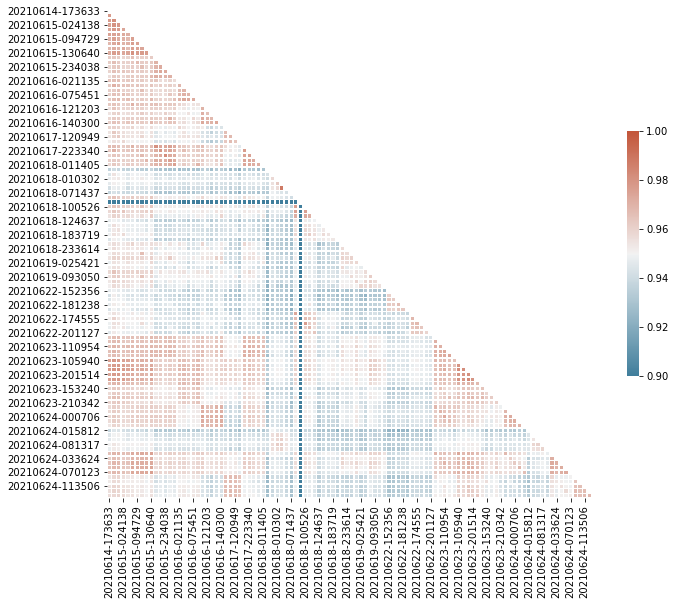

In [8]:
corr = oofs[pred_cols].corr()

mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmin=0.9, vmax=1.0, # center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5});

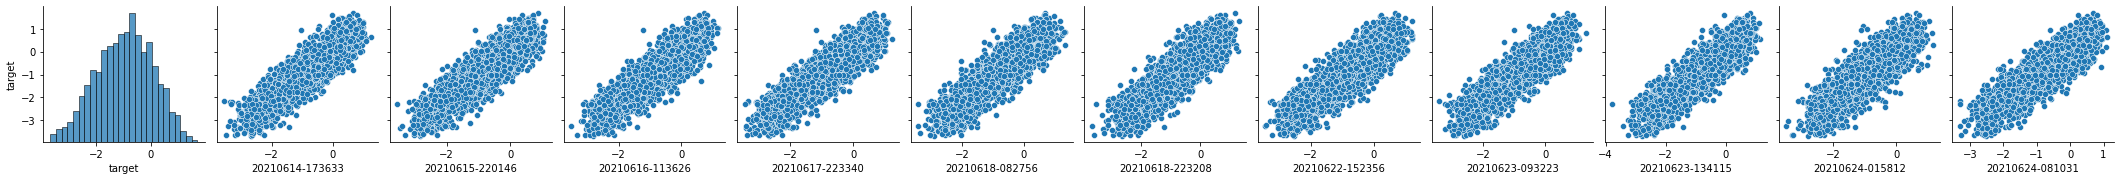

In [9]:
sns.pairplot(oofs, y_vars=["target"], x_vars=["target"] + pred_cols[::10]);

In [10]:
scores = cross_val_score(
#     LinearRegression(),
    Ridge(alpha=100),
#     KernelRidge(alpha=100, kernel="rbf"),
#     BaggingRegressor(n_estimators=100),
#     Lasso(),
    oofs[pred_cols],
    oofs["target"],
    scoring="neg_mean_squared_error",
#     cv=LeaveOneOut(),
    n_jobs=-1,
)
print(f"Best score: {np.sqrt(np.mean(-scores)):0.5f}")

Best score: 0.44868


In [11]:
# # reg = LassoCV(max_iter=5000, cv=LeaveOneOut(), n_jobs=-1)  # 0.45689
# reg = ElasticNetCV(l1_ratio=[0.01, 0.05, .1, .5, .7, .9, .95, .99, 1], max_iter=5000, n_jobs=-1, tol=1e-5)  # 0.45619

# reg.fit(oofs[pred_cols], oofs["target"])
# # print(f"Best score: {np.sqrt(reg.mse_path_[-1].mean()):0.5f}")
# print(reg.l1_ratio_)

# np.sqrt(reg.mse_path_[1, -1].mean())

# Brute force model selection

In [12]:
# def powerset(iterable):
#     "powerset([1,2,3]) --> () (1,) (2,) (3,) (1,2) (1,3) (2,3) (1,2,3)"
#     s = list(iterable)  # allows duplicate elements
#     return itertools.chain.from_iterable(itertools.combinations(s, r) for r in range(len(s)+1))

# subsets = list(powerset(pred_cols))
# len(subsets)

In [13]:
# best_score = 10
# best_cols = None

# for s in tqdm(subsets[1:]):
#     reg = RidgeCV(alphas=(0.01, 0.05, 0.1, 0.5, 1.0, 5.0, 10.0, 50, 100, 500, 1000))
#     reg.fit(oofs[list(s)], oofs["target"])
#     score = np.sqrt(-reg.best_score_)
    
#     if score < best_score:
#         best_score = score
#         best_cols = list(s)
        
# print(f"Best score: {best_score:0.5f}")
# print("Best cols", best_cols)

In [14]:
# ['model_1', 'model_2', 'model_4', 'model_5', 'model_6', 'model_7', 'model_8', 'model_9', 'model_11', 'model_13', 'model_16']

# Hill climbing

In [15]:
def get_score(X, y):
    #     reg = RidgeCV(alphas=(0.01, 0.05, 0.1, 0.5, 1.0, 5.0, 10.0, 50, 100, 500, 1000), normalize=True)
    #     reg.fit(X, y)
    #     return np.sqrt(-reg.best_score_)
    reg = LassoCV(
        max_iter=5000,
        random_state=48,
        n_jobs=-1,
        normalize=True,
#         cv=RepeatedKFold(random_state=48),
    ).fit(X, y)
    return np.sqrt(reg.mse_path_)[-1].mean()


def averaging(X, y):
    y_pred = X.mean(1)
    return np.sqrt(mean_squared_error(y_pred, y))

In [16]:
candidates = model_folders.copy()

best_score = np.inf
selection = []
# tol = 0.00001
tol = 0
y = oofs["target"]

# Find best initial model
initial_scores = [np.sqrt(mean_squared_error(oofs[c], oofs["target"])) for c in candidates]
idx = np.argmin(initial_scores)
best_score = initial_scores[idx]
selection.append(candidates[idx])
print(f"Initial {candidates[idx]}. Score {best_score:0.5f}")
del candidates[idx]


while True:
    scores = [get_score(oofs[selection + [c]], y) for c in candidates]
#     scores = [averaging(oofs[selection + [c]], y) for c in candidates]

    idx = np.argmin(scores)
    if scores[idx] < best_score - tol:
        best_score = scores[idx]
        selection.append(candidates[idx])
        print(f"Added {candidates[idx]}. New best score {best_score:0.5f}")
        del candidates[idx]
    else:
        break
        
print(len(selection), "models selected")
        
selection

Initial 20210623-232231. Score 0.47171
Added 20210616-041221. New best score 0.45762
Added 20210617-135233. New best score 0.45364
Added 20210624-012102. New best score 0.45147
Added 20210619-004022. New best score 0.45058
Added 20210624-113506. New best score 0.44959
Added 20210615-234038. New best score 0.44890
Added 20210619-035747. New best score 0.44836
Added 20210624-101855. New best score 0.44769
Added 20210618-223208. New best score 0.44719
Added 20210624-015812. New best score 0.44681
Added 20210618-092115. New best score 0.44649
Added 20210616-060255. New best score 0.44619
Added 20210624-150250. New best score 0.44601
Added 20210623-201514. New best score 0.44583
Added 20210618-203441. New best score 0.44562
Added 20210624-044356. New best score 0.44549
Added 20210615-094729. New best score 0.44534
Added 20210614-203831. New best score 0.44515
Added 20210623-170657. New best score 0.44500
Added 20210622-152356. New best score 0.44487
Added 20210615-084357. New best score 0.4

['20210623-232231',
 '20210616-041221',
 '20210617-135233',
 '20210624-012102',
 '20210619-004022',
 '20210624-113506',
 '20210615-234038',
 '20210619-035747',
 '20210624-101855',
 '20210618-223208',
 '20210624-015812',
 '20210618-092115',
 '20210616-060255',
 '20210624-150250',
 '20210623-201514',
 '20210618-203441',
 '20210624-044356',
 '20210615-094729',
 '20210614-203831',
 '20210623-170657',
 '20210622-152356',
 '20210615-084357',
 '20210616-132341',
 '20210619-014809',
 '20210615-105329',
 '20210618-010302']

In [17]:
model_folders_current = [
    "20210614-234025",
    "20210616-041221",
    "20210617-135233",
    "20210615-225055",
    "20210618-030706",
    "20210619-035747",
    "20210614-173633",
    "20210616-060255",
    "20210619-004022",
    "20210616-132341",
    "20210617-102611",
    "20210618-223208",
    "20210615-094729",
    "20210615-234038",
    "20210618-092115",
    "20210616-003038",
    "20210616-075451",
    "20210615-105329",
    "20210617-232650",
    "20210614-203831",
    "20210618-183719",
    "20210622-152356",
]

model_folders_new = [
    "20210623-232231",
    "20210616-041221",
    "20210617-135233",
    "20210624-012102",
    "20210619-004022",
    "20210624-113506",
    "20210615-234038",
    "20210619-035747",
    "20210624-101855",
    "20210618-223208",
    "20210624-015812",
    "20210618-092115",
    "20210616-060255",
    "20210624-150250",
    "20210623-201514",
    "20210618-203441",
    "20210624-044356",
    "20210615-094729",
    "20210614-203831",
    "20210623-170657",
    "20210622-152356",
    "20210615-084357",
    "20210616-132341",
    "20210619-014809",
    "20210615-105329",
    "20210618-010302",
]
model_folders_current = set(model_folders_current)
model_folders_new = set(model_folders_new)

In [18]:
# Add these
model_folders_new.difference(model_folders_current)

{'20210615-084357',
 '20210618-010302',
 '20210618-203441',
 '20210619-014809',
 '20210623-170657',
 '20210623-201514',
 '20210623-232231',
 '20210624-012102',
 '20210624-015812',
 '20210624-044356',
 '20210624-101855',
 '20210624-113506',
 '20210624-150250'}

In [19]:
# Remove these
model_folders_current.difference(model_folders_new)

{'20210614-173633',
 '20210614-234025',
 '20210615-225055',
 '20210616-003038',
 '20210616-075451',
 '20210617-102611',
 '20210617-232650',
 '20210618-030706',
 '20210618-183719'}

# Matching Seeds

In [29]:
def fetch_group(n):
    return model_folders[n*5:5*(n+1)]

fetch_group(2)

['20210615-220146',
 '20210615-225055',
 '20210615-234038',
 '20210616-003038',
 '20210616-012048']

In [21]:
n_groups = len(model_folders) // 5
groups = list(range(n_groups))

best_score = np.inf
selected_groups = [15]
# tol = 0.00001
tol = 0
y = oofs["target"]


while True:
    selection = []
    for s in selected_groups:
        selection.extend(fetch_group(s))
        
    scores = []
    for g in groups:
        sel = np.array(selection + fetch_group(g)).reshape(-1, 5)
        y_pred = 0
        for i in range(5):
            reg = LassoCV(
                max_iter=5000,
                random_state=48,
                n_jobs=-1,
                normalize=True,
            ).fit(oofs[sel[:, i]], y)
            y_pred += reg.predict(oofs[sel[:, i]])
        scores.append(np.sqrt(mean_squared_error(y_pred / 5, y)))
        
    idx = np.argmin(scores)
    if scores[idx] < best_score - tol:
        best_score = scores[idx]
        selected_groups.append(groups[idx])
        print(f"Added {groups[idx]}. New best score {best_score:0.5f}")
        del groups[idx]
    else:
        break
        
print(len(selected_groups), "groups selected")
        
selected_groups

Added 5. New best score 0.45403
Added 3. New best score 0.45218
Added 17. New best score 0.45145
Added 10. New best score 0.45108
Added 20. New best score 0.45072
Added 2. New best score 0.45031
Added 11. New best score 0.44984
Added 18. New best score 0.44942
Added 7. New best score 0.44918
Added 12. New best score 0.44901
Added 19. New best score 0.44883
Added 1. New best score 0.44858
Added 4. New best score 0.44828
Added 0. New best score 0.44814
Added 9. New best score 0.44799
Added 13. New best score 0.44796
17 groups selected


[15, 5, 3, 17, 10, 20, 2, 11, 18, 7, 12, 19, 1, 4, 0, 9, 13]

In [28]:
top5 = []
for x in selected_groups[:4]:
    top5.extend(fetch_group(x))
    
top5

['20210623-105940',
 '20210623-140343',
 '20210623-170657',
 '20210623-201514',
 '20210623-232231',
 '20210617-083847',
 '20210617-102611',
 '20210617-120949',
 '20210617-135233',
 '20210617-153459',
 '20210616-021135',
 '20210616-041221',
 '20210616-060255',
 '20210616-075451',
 '20210616-094506',
 '20210623-225426',
 '20210623-233019',
 '20210624-000706',
 '20210624-004429',
 '20210624-012102']

Need to upload
```
'20210616-041221',
'20210616-075451',
'20210623-225426',
'20210623-233019',
'20210624-000706',
'20210624-004429',
```

# Feature selection

In [22]:
from sklearn.feature_selection import RFECV, SequentialFeatureSelector

In [23]:
# # estimator = RidgeCV(
# #     alphas=(0.01, 0.05, 0.1, 0.5, 1.0, 5.0, 10.0, 50, 100, 500, 1000), normalize=True
# # )
# estimator = LassoCV(max_iter=5000, random_state=48, n_jobs=-1, normalize=True)

# selector = SequentialFeatureSelector(
#     estimator,
#     scoring="neg_mean_squared_error",
#     n_jobs=-1,
# )
# selector = selector.fit(oofs[pred_cols], oofs["target"])
# print(selector.n_features_to_select_)

# pred_cols = np.array(pred_cols)
# pred_cols[selector.support_]

In [24]:
# scores = cross_val_score(
#     estimator,
#     oofs[pred_cols[selector.support_]],
#     oofs["target"],
#     scoring="neg_mean_squared_error",
#     cv=LeaveOneOut(),
#     n_jobs=-1,
# )
# print(f"Best score: {np.sqrt(np.mean(-scores)):0.5f}")

# GBT

In [25]:
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import HistGradientBoostingRegressor

In [26]:
# kf = KFold(shuffle=True, random_state=48)
# scores = []

# for fold, (trn_idx, val_idx) in enumerate(kf.split(oofs[pred_cols], oofs["target"])):
#     X_train, y_train = oofs.loc[trn_idx, pred_cols], oofs.loc[trn_idx, "target"]
#     X_valid, y_valid = oofs.loc[val_idx, pred_cols], oofs.loc[val_idx, "target"]

# #     reg = HistGradientBoostingRegressor(
# #         learning_rate=0.01,
# #         max_iter=1000,
# #         max_leaf_nodes=15,
# #         l2_regularization=0.0,
# #         early_stopping=True,
# #         n_iter_no_change=100,
# #     )
# #     reg = GaussianProcessRegressor(normalize_y=True, alpha=0.4)
# #     reg = MLPRegressor(max_iter=20000, early_stopping=True, n_iter_no_change=100, alpha=0.001)
# #     reg = SVR(kernel="linear", C=0.01, epsilon=0.001)
# #     reg = TheilSenRegressor(n_jobs=-1)
#     reg = RANSACRegressor(base_estimator=Ridge(alpha=50), loss="squared_loss", max_trials=1000)
#     reg.fit(X_train, y_train)
#     y_pred = reg.predict(X_valid)
#     score = np.sqrt(mean_squared_error(y_pred, y_valid))
#     scores.append(score)
#     print(f"Fold {fold} RMSE: {score:0.5f}")
# print(f"Final RMSE: {np.mean(scores):0.5f}")